## Potential flow and Joukowski transform

Philipp Schlatter, 2025 (adapted from Barba et al. Aeropython)

Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/kutta-joukowski.ipynb

<a target="_blank" href="https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/kutta-joukowski.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Preliminaries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures
  !pip install -q ipympl
  get_ipython().kernel.do_shutdown(restart=True)

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures
  # !pip install -q ipympl
  #get_ipython().kernel.do_shutdown(restart=True)
  from google.colab import output
  output.enable_custom_widget_manager()

In [3]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt

### Parameters

In [4]:
x_center, y_center = -0.0, 0.0          # plate
#x_center,y_center = -0.2,0.             # symmetric profile
x_center, y_center = -0.2, 0.2         # cambered airfoil (thin)
#x_center, y_center = -0.5, 0.5         # cambered airfoil (thick)
#x_center, y_center = -0, 0.2           # camber
#x_center, y_center = -0.08, 0.08       # wiki


u_inf = 1             # free-stream speed
alpha = 10*(np.pi/180)  # angle of attack

In [5]:
R = np.sqrt((1-x_center)**2+y_center**2)   # circle needs to go through (1,0)
M = (R**2)*2*np.pi*u_inf  # doublet for circle with radius R
Gamma = -4*np.pi*R*u_inf*np.sin(alpha + np.arcsin(y_center/R))  # Kutta condition for AoA alpha
#Gamma = +15

### Definition of the mesh

In [6]:
class Cartesian:
    def __init__(self,N,x_start,x_end,y_start,y_end):
        self.X, self.Y = np.meshgrid(np.linspace(x_start, x_end, N), np.linspace(y_start, y_end, N))
        self.type = "Cartesian"
        
class Polar:
    def __init__(self,N,r_start,r_end):
        xx,yy = np.meshgrid(np.linspace(r_start,r_end,N),np.linspace(0,2*np.pi,N,endpoint=True))
        self.X, self.Y = xx*np.cos(yy)+x_center,xx*np.sin(yy)+y_center
        self.type = "Polar"
        
class Velocity:
    def __init__(self,mesh):
        self.u = mesh.X*0
        self.v = mesh.X*0
        self.p = mesh.X*0
        
    def comp_p(self,u_ref):
        self.p = 2*(0.5*u_ref**2-0.5*(self.u**2 + self.v**2))

In [7]:
# for a Kutta-Joukoswski airfoil, we choose a polar mesh
mesh = Polar(100,R,10)

### Elementary flow solutions

In [8]:
class Doublet:
    # strength M
    def __init__(self, strength, x, y):
        self.strength = strength
        self.x, self.y = x, y

    def vel(self, mesh):
        u = (-self.strength / (2 * np.pi) *
             ((mesh.X - self.x)**2 - (mesh.Y - self.y)**2) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        v = (-self.strength / (2 * np.pi) *
             2 * (mesh.X - self.x) * (mesh.Y - self.y) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        return u, v

    def psi(self, mesh):
        psi = -(self.strength / (2 * np.pi) *
               (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        return psi

In [9]:
class Vortex:
    def __init__(self, strength, x, y):
        self.strength = strength  # Gamma
        self.x, self.y = x, y

    def vel(self, mesh):
        u = -self.strength / (2 * np.pi) * (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        v = +self.strength / (2 * np.pi) * (mesh.X - self.x) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return u, v

    def psi(self, mesh):
        psi =  -self.strength / ( 4*np.pi) * np.log((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return psi

In [10]:
class Freestream:
    def __init__(self, strength, alpha):
        self.strength = strength
        self.alpha = alpha
        
    def vel(self, mesh):
        u = mesh.X*0 + self.strength*np.cos(self.alpha) 
        v = mesh.X*0 + self.strength*np.sin(self.alpha) 
        return u, v
            
    def psi(self, mesh):
        psi = self.strength*(-mesh.X*np.sin(self.alpha) + mesh.Y*np.cos(self.alpha))
        return psi

### Rotating cylinder

In [11]:
# Flow around a cylinder
fst = Freestream(u_inf,0)
u1,v1 = fst.vel(mesh)
psi1 = fst.psi(mesh)

doublet = Doublet(strength=M, x=x_center,y=y_center)
u2, v2 = doublet.vel(mesh)
psi2 = doublet.psi(mesh)

vortex = Vortex(strength=Gamma, x=x_center,y=y_center)
u3, v3 = vortex.vel(mesh)
psi3 = vortex.psi(mesh)

U = Velocity(mesh)
U.u = u1+u2+u3
U.v = v1+v2+v3
psi = psi1+psi2+psi3

# R = np.sqrt(M/(2*np.pi*u_inf))

theta = np.linspace(0.0, 2 * np.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))

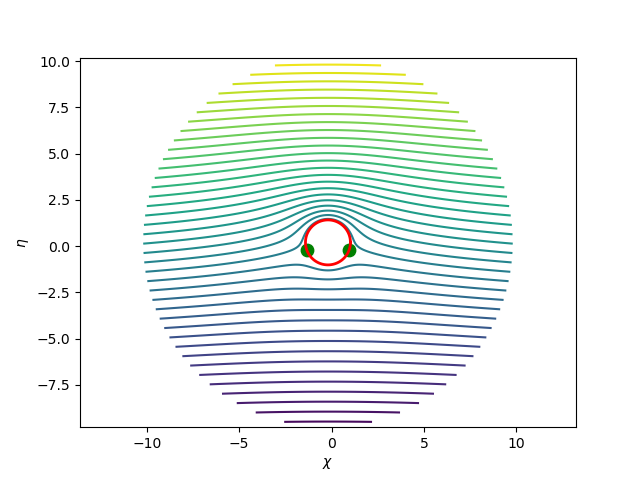

In [12]:
# streamfunction and stagnation points
plt.figure()
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\eta$')
plt.axis('equal')
plt.contour(mesh.X, mesh.Y, psi,40)
plt.plot(x_cylinder, y_cylinder, color='r', linestyle='-', linewidth=2)
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');
plt.show()

C:\Users\pschl\AppData\Local\Temp\ipykernel_20060\1413838563.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmin=-2,cmap='jet')


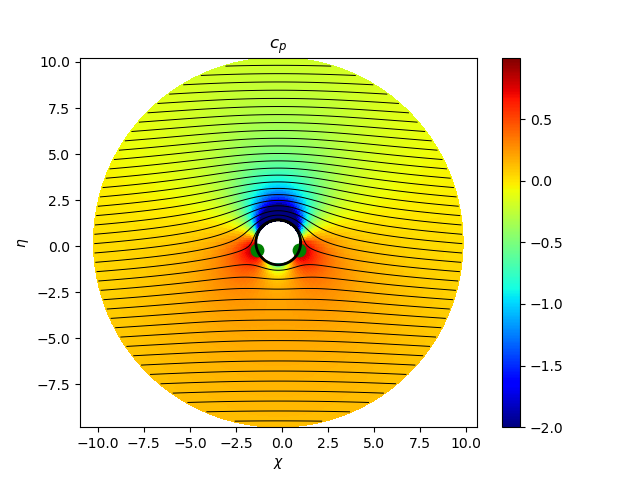

In [13]:
U.comp_p(u_inf)
plt.figure()
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\eta$')
plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmin=-2,cmap='jet')
plt.axis('equal')
plt.colorbar()
plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)

plt.contour(mesh.X, mesh.Y, psi, levels=np.arange(-40,40,0.5),linewidths=0.7,linestyles='-',colors='k')
plt.title('$c_p$')
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');

plt.show()

### Joukowski transform

Conformal mapping:
$$Z = \left(\zeta + \frac{1}{\zeta}\right) e^{-i \alpha}$$
including rotation with the angle of attack $\alpha$. We first rotate the cylinder flow around the cylinder centre, such that the free-stream orientation after conformal mapping is horizontal.

In [14]:
xi = (mesh.X + 1j*mesh.Y - (x_center+1j*y_center))*np.exp(1j*alpha) +  (x_center+1j*y_center)
xi_cyl = (x_cylinder + 1j*y_cylinder - (x_center+1j*y_center))*np.exp(1j*alpha)+  (x_center+1j*y_center)

In [15]:
Z = (1/xi + xi)*np.exp(-1j*alpha)
Z_cyl = (1/xi_cyl + xi_cyl)*np.exp(-1j*alpha)

In [16]:
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    
xi_stagn1 = (x_stagn1 + 1j*y_stagn1- (x_center+1j*y_center))*np.exp(1j*alpha)+  (x_center+1j*y_center)
Z_stagn1 = (1/xi_stagn1 + xi_stagn1)*np.exp(-1j*alpha)

xi_stagn2 = (x_stagn2 + 1j*y_stagn2- (x_center+1j*y_center))*np.exp(1j*alpha)+  (x_center+1j*y_center)
Z_stagn2 = (1/xi_stagn2 + xi_stagn2)*np.exp(-1j*alpha)    

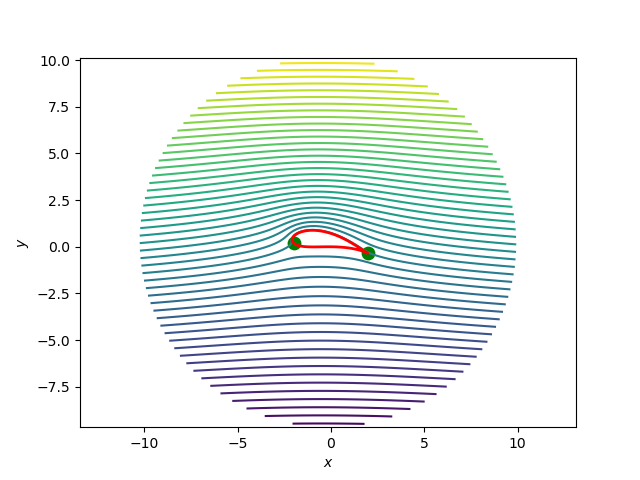

In [17]:
plt.figure()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.axis('equal')
plt.contour(np.real(Z), np.imag(Z), psi,50)
plt.plot(np.real(Z_cyl), np.imag(Z_cyl), color='r', linestyle='-', linewidth=2)


plt.scatter([np.real(Z_stagn1),np.real(Z_stagn2)], [np.imag(Z_stagn1),np.imag(Z_stagn2)],
               color='g', s=80, marker='o');
plt.show()

C:\Users\pschl\AppData\Local\Temp\ipykernel_20060\3892201901.py:4: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(np.real(Z),np.imag(Z), U.p/u_inf**2,vmin=-2,cmap='jet')


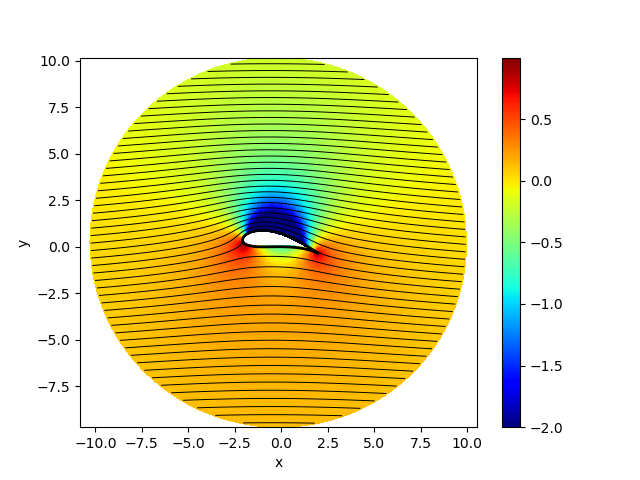

In [18]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.pcolor(np.real(Z),np.imag(Z), U.p/u_inf**2,vmin=-2,cmap='jet')
plt.colorbar()
plt.contour(np.real(Z), np.imag(Z), psi,60,linewidths=0.7,linestyles='-',colors='k')
plt.axis('equal')
plt.plot(np.real(Z_cyl), np.imag(Z_cyl), color='k', linestyle='-', linewidth=2)
plt.show()
#plt.savefig("test.svg")

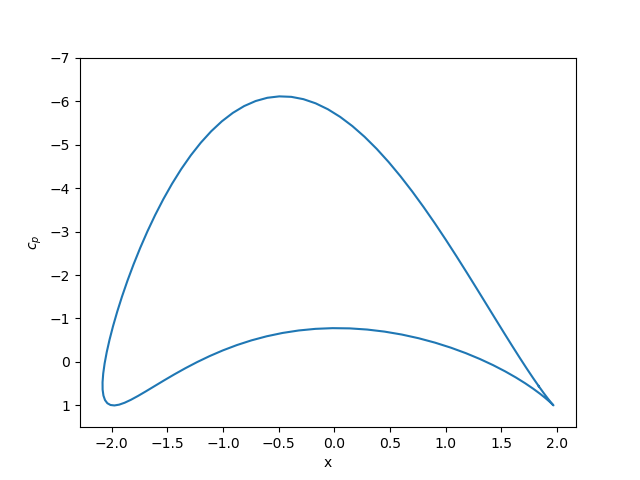

In [19]:
plt.figure()
plt.plot(np.real(Z[:,0]),U.p[:,0]/u_inf**2)
plt.xlabel('x')
plt.ylabel(r'$c_p$')
plt.ylim(1.5,-7)
plt.show()

### Comparison to analytical predictions:

Lift per unit span: $F_L'=F_L/b = -\rho \Gamma U_\infty$

Thickness ratio: $t/c \approx \frac{3\sqrt{3}}{4} |x_\mathrm{center}|$

Kutta condition: $\Gamma = -4 \pi R U_\infty \sin(\alpha+\arcsin(y_\mathrm{center}/R))$

Lift coefficient: $C_L = F_L/(\frac12 \rho U_\infty^2 c b)$

For a flat plate: $C_L = 2  \Gamma / (U_\infty c) =  8\pi\sin(\alpha) (R/c) = 2 \pi \sin(\alpha)$, with $c=4R$, which is the same as for thin airfoil theory.

For a thick and cambered airfoil: $C_L = 2  \Gamma / (U_\infty c)  
\approx 2 \pi (1+\frac{4}{3\sqrt{3}} \frac{t}{c})\sin(\alpha+\arcsin(y_\mathrm{center}/R))$. 


Lift slope: $\frac{\mathrm d C_L}{\mathrm d \alpha} = 2\pi$ (at $\alpha-\alpha_0$)

Zero-lift angle $\sin(\alpha_0) = -\frac{y_\mathrm{center}}{R}$

In [20]:
# Lift coefficient C_L from Kutta-Joukowski theorem
alpha0 = -np.arcsin(y_center/R)   # zero-lift angle for cambered profiles
c = 4  # approximation for Joukowski profiles (a bit longer than 4)
cl=-2*Gamma/u_inf/c
print('Radius of the circle: R = {:0.5f}'.format(R))
print('measured chord length: R = {:0.5f}'.format(np.max(np.real(Z[:,0]))-np.min(np.real(Z[:,0]))/np.cos(alpha)))
print('angle of zero lift: alpha_0 = {:0.5f}'.format(alpha0*180/np.pi))
print('lift coefficient: CL = {:0.5f}'.format(cl))
print('lift slope: dCL/dalpha = {:0.5f}'.format(cl/(alpha-alpha0)))

Radius of the circle: R = 1.21655
measured chord length: R = 4.08271
angle of zero lift: alpha_0 = -9.46232
lift coefficient: CL = 2.54682
lift slope: dCL/dalpha = 7.49768


In [21]:
# analytical values for Joukowski profiles, for finite thickness
thickness = 3*np.sqrt(3)/4*np.abs(x_center)
print('thickness ratio t/c = {:0.5f}'.format(thickness))
print('')
print('Taking thickness into account:')
print('lift coefficient: CL = {:0.5f}'.format(2.*np.pi*(1+4/3/np.sqrt(3)*thickness)*np.sin(alpha-alpha0)))
print('lift slope: dCL/dalpha = {:0.5f}'.format(2.*np.pi*(1+4/3/np.sqrt(3)*thickness)*np.sin(alpha-alpha0)/(alpha-alpha0)))

print('')
print('Taking thickness and camber into account:')
print('lift coefficient: CL = {:0.5f}'.format(8.*np.pi*(R/c)*np.sin(alpha-alpha0)))
print('lift slope: dCL/dalpha = {:0.5f}'.format(8.*np.pi*(R/c)*np.sin(alpha-alpha0)/(alpha-alpha0)))

thickness ratio t/c = 0.25981

Taking thickness into account:
lift coefficient: CL = 2.51217
lift slope: dCL/dalpha = 7.39566

Taking thickness and camber into account:
lift coefficient: CL = 2.54682
lift slope: dCL/dalpha = 7.49768


In [22]:
# analytical value for a flat plate, for zero thickness
cl_th=2*np.pi*np.sin(alpha-alpha0)
print('thickness ratio t/c = {:0.5f}'.format(0))
print('lift coefficient: CL = {:0.5f}'.format(cl_th))
print('lift slope: dCL/dalpha = {:0.5f}'.format(2*np.pi))

thickness ratio t/c = 0.00000
lift coefficient: CL = 2.09348
lift slope: dCL/dalpha = 6.28319


### Wing profile

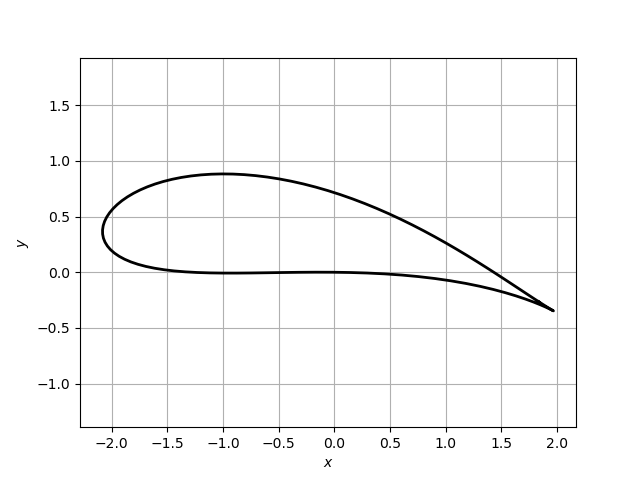

In [23]:
plt.figure()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.axis('equal')
plt.grid()
plt.plot(np.real(Z_cyl), np.imag(Z_cyl), color='k', linestyle='-', linewidth=2)
plt.show()

### Lift over angle of attack

In [24]:
alpha_p = alpha
cl_p = cl

In [25]:
alpha_p= np.append(alpha_p, alpha)
cl_p= np.append(cl_p, cl)


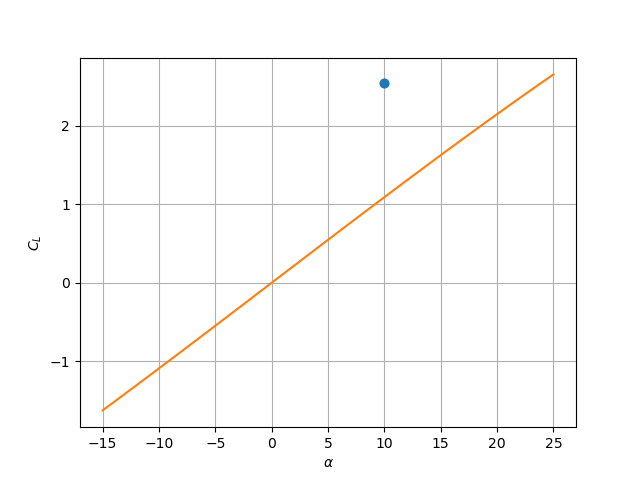

In [26]:
plt.figure()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_L$')
plt.grid()
plt.plot(alpha_p*180/np.pi,cl_p,'o')
xx=np.linspace(-15,25)
plt.plot(xx,2*np.pi*np.sin(xx*np.pi/180))
plt.show()

In [27]:
plt.savefig("ppp.svg")

In [28]:
R

1.2165525060596438